# LOO

## Similarity measure evaluation
The sentence similarity measure used in LOO is evaluated on the [STS dataset](https://huggingface.co/datasets/sentence-transformers/stsb), containing sentence pair similarity annoted by humans.

In [2]:
from pathlib import Path

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import torch
from datasets import load_dataset
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import pandas as pd

from experiment_result import (
    ExperimentResult,
    load_json_file,
    cumsum_to_differences,
    find_arg,
    TEST_TO_VARIABLE_NAME,
)

/home/rick/miniconda3/envs/fact2/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/rick/miniconda3/envs/fact2/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/rick/miniconda3/envs/fact2/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/i

In [3]:
encoder = SentenceTransformer('all-MiniLM-L6-v2')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = encoder.to(device)

In [4]:
# STS dataset from huggingface 
sts_dataset = load_dataset("sentence-transformers/stsb")
test_sts_dataset = sts_dataset.get("test")

In [5]:
rng = np.random.default_rng(42)
random_idx = rng.integers(
    0,
    len(test_sts_dataset),
    size=3
)

In [6]:
for idx, sentence_idx in enumerate(random_idx):
    sentence_pair_similarity = test_sts_dataset[int(sentence_idx)]
    sentence_1 = sentence_pair_similarity["sentence1"]
    sentence_2 = sentence_pair_similarity["sentence2"]
    pair = [sentence_1, sentence_2]
    encoded_sentences = encoder.encode(pair)
    similarity = cosine_similarity(encoded_sentences[0:1], encoded_sentences[1:2])[0][0]

    print("\n".join((
        sentence_1,
        sentence_2,
        f"Score: {sentence_pair_similarity['score']}, Predicted similarity: {similarity}"
    )), "\n")

Meat is being put into a skillet.
A woman is putting a baby into a trash can.
Score: 0.08, Predicted similarity: 0.06008782237768173 

I think we made the right case and did the right thing."
Mr Blair went on: "I think we did the right thing in relation to Iraq.
Score: 0.55, Predicted similarity: 0.5586274862289429 

The consensus among Wall Street analysts was for a loss of 28 cents a share.
Analysts surveyed by First Call were expecting sales of $723 million and a loss of 28 cents a share.
Score: 0.6, Predicted similarity: 0.6452685594558716 



In [7]:
similarity_diff = []

for idx, sentence_pair_similarity in tqdm(enumerate(test_sts_dataset), total=len(test_sts_dataset)):
    sentence_1 = sentence_pair_similarity["sentence1"]
    sentence_2 = sentence_pair_similarity["sentence2"]
    pair = [sentence_1, sentence_2]
    encoded_sentences = encoder.encode(pair)
    similarity = cosine_similarity(encoded_sentences[0:1], encoded_sentences[1:2])[0][0]

    diff = np.abs(sentence_pair_similarity['score'] - similarity)
    similarity_diff.append(diff)
similarity_diff = np.array(similarity_diff)

  0%|          | 0/1379 [00:00<?, ?it/s]

In [8]:
print("Similarity diff mean:", np.mean(similarity_diff))
print("Similarity diff std:", np.std(similarity_diff))
print("Similarity diff min:", np.min(similarity_diff))
print("Similarity diff max:", np.max(similarity_diff))


Similarity diff mean: 0.14835433662926442
Similarity diff std: 0.1216799930457631
Similarity diff min: 6.411552429197442e-05
Similarity diff max: 0.735506172478199


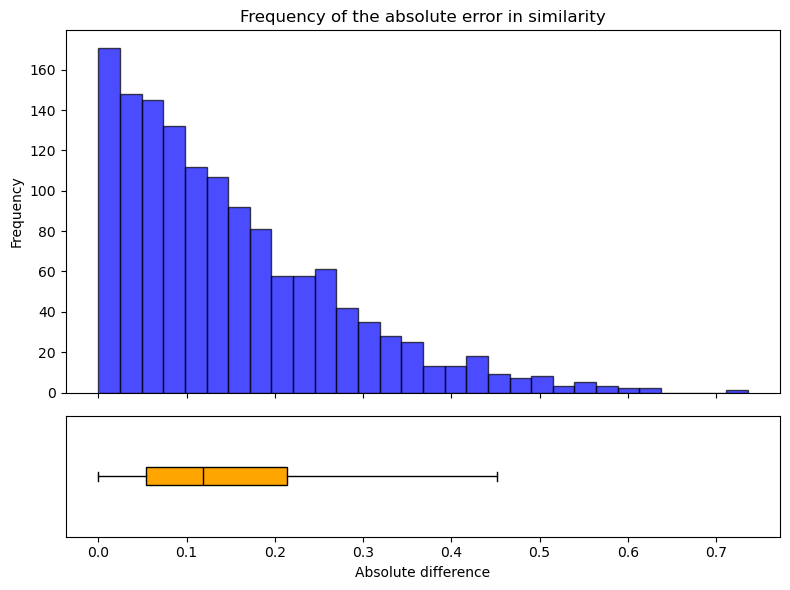

In [9]:
# Create a figure with two subplots

fig, (ax_hist, ax_box) = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={"height_ratios": (3, 1)}, figsize=(8, 6)
)

# Plot histogram
ax_hist.hist(similarity_diff, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax_hist.set_ylabel('Frequency')

# Plot boxplot
ax_box.boxplot(similarity_diff, vert=False, patch_artist=True,
               boxprops=dict(facecolor='orange', color='black'),
               medianprops=dict(color='black'),
               showfliers=False)
ax_box.set_xlabel('Absolute difference')
ax_box.yaxis.set_visible(False)

# Set title and adjust layout
ax_hist.set_title('Frequency of the absolute error in similarity')
plt.tight_layout()
plt.show()

## LOO Thresold

In [10]:
result_dir = Path("results")

In [11]:
STS_SIMILARITY_THRESHOLD = 0.6

In [12]:
train_sts_dataset = sts_dataset.get("train")

pred_train_similarity = []
true_train_similar = []

for idx, sentence_pair_similarity in tqdm(enumerate(train_sts_dataset), total=len(train_sts_dataset)):
    sentence_1 = sentence_pair_similarity["sentence1"]
    sentence_2 = sentence_pair_similarity["sentence2"]
    pair = [sentence_1, sentence_2]
    encoded_sentences = encoder.encode(pair)
    similarity = cosine_similarity(encoded_sentences[0:1], encoded_sentences[1:2])[0][0]

    similar = False
    if sentence_pair_similarity['score'] >= STS_SIMILARITY_THRESHOLD:
        similar = True

    pred_train_similarity.append(similarity)
    true_train_similar.append(similar)

pred_train_similarity = np.array(pred_train_similarity)
true_train_similar = np.array(true_train_similar)

  0%|          | 0/5749 [00:00<?, ?it/s]

Intersection point: 0.6793587174348696


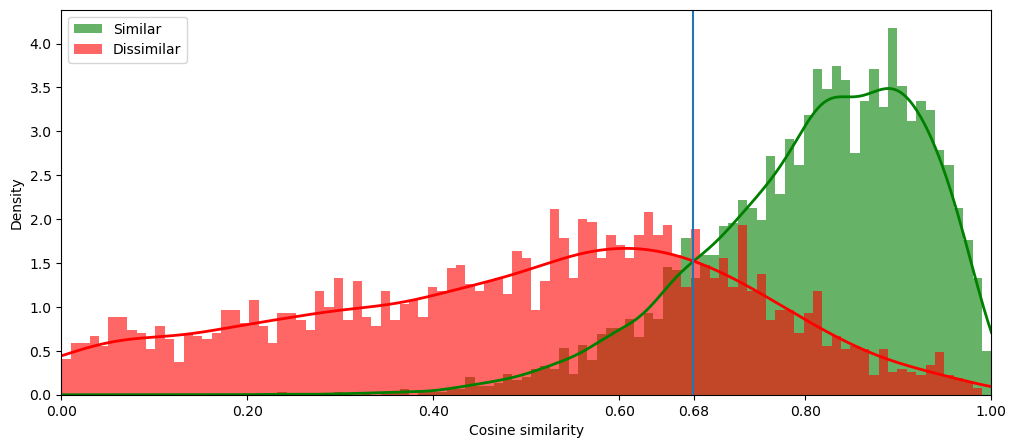

In [13]:
from scipy.stats import gaussian_kde

# Separate scores based on the binary labels
right_matches = pred_train_similarity[true_train_similar]
wrong_matches = pred_train_similarity[~true_train_similar]


bins = np.linspace(0, 1, 100)


# Create the figure and axis
plt.figure(figsize=(12, 5))

plt.hist(right_matches, bins=bins, density=True, alpha=0.6, color='green', label="Similar")
plt.hist(wrong_matches, bins=bins, density=True, alpha=0.6, color='red', label="Dissimilar")

# KDE (Kernel Density Estimation) for smooth curves
kde_right = gaussian_kde(right_matches)
kde_wrong = gaussian_kde(wrong_matches)

x_vals = np.linspace(0, 1, 500)
kde_right_vals = kde_right(x_vals)
kde_wrong_vals = kde_wrong(x_vals)

# Find the point where rights and wrongs cross
diff = kde_right_vals - kde_wrong_vals
zero_crossings = np.where(np.diff(np.sign(diff)))[0]

intersection_points = x_vals[zero_crossings]
print("Intersection point:", intersection_points[0])

plt.plot(x_vals, kde_right_vals, color='green', linewidth=2)
plt.plot(x_vals, kde_wrong_vals, color='red', linewidth=2)


plt.xlim(0.0, 1.0)
plt.axvline(intersection_points[0])
xticks = list(plt.xticks()[0])
xticks.append(round(intersection_points[0], 2))
plt.xticks(sorted(xticks))

# Labels and legend
plt.xlabel("Cosine similarity")
plt.ylabel("Density")
plt.legend()
plt.show()

In [14]:
similarity_threshold = 0.68

pred_test_similar = []
true_test_similar = []

for idx, sentence_pair_similarity in tqdm(enumerate(test_sts_dataset), total=len(test_sts_dataset)):
    sentence_1 = sentence_pair_similarity["sentence1"]
    sentence_2 = sentence_pair_similarity["sentence2"]
    pair = [sentence_1, sentence_2]
    encoded_sentences = encoder.encode(pair)
    similarity = cosine_similarity(encoded_sentences[0:1], encoded_sentences[1:2])[0][0]

    similar = False
    if sentence_pair_similarity['score'] >= STS_SIMILARITY_THRESHOLD:
        similar = True
    
    pred_similar = False
    if similarity >= similarity_threshold:
        pred_similar = True

    pred_test_similar.append(pred_similar)
    true_test_similar.append(similar)

pred_test_similar = np.array(pred_test_similar).astype(float)
true_test_similar = np.array(true_test_similar).astype(float)

  0%|          | 0/1379 [00:00<?, ?it/s]

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(true_test_similar, pred_test_similar)
precision = precision_score(true_test_similar, pred_test_similar)
recall = recall_score(true_test_similar, pred_test_similar)
f1 = f1_score(true_test_similar, pred_test_similar)

# Print Results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

Accuracy: 0.815
Precision: 0.819
Recall: 0.798
F1-Score: 0.808
